In [1]:
import copy
import math
import random
from collections import namedtuple, OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.nn import parameter
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *

from fast_pytorch_kmeans import KMeans

/home/bwang/miniconda3/envs/6.5931/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [4]:
def download_url(url, model_dir='.', overwrite=False):
    import os, sys
    from urllib.request import urlretrieve
    target_dir = url.split('/')[-1]
    model_dir = os.path.expanduser(model_dir)
    try:
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model_dir = os.path.join(model_dir, target_dir)
        cached_file = model_dir
        if not os.path.exists(cached_file) or overwrite:
            sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
            urlretrieve(url, cached_file)
        return cached_file
    except Exception as e:
        # remove lock file so download can be executed next time.
        os.remove(os.path.join(model_dir, 'download.lock'))
        sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
        return None

In [5]:
class VGG(nn.Module):
  ARCH = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

  def __init__(self) -> None:
    super().__init__()

    layers = []
    counts = defaultdict(int)

    def add(name: str, layer: nn.Module) -> None:
      layers.append((f"{name}{counts[name]}", layer))
      counts[name] += 1

    in_channels = 3
    for x in self.ARCH:
      if x != 'M':
        # conv-bn-relu
        add("conv", nn.Conv2d(in_channels, x, 3, padding=1, bias=False))
        add("bn", nn.BatchNorm2d(x))
        add("relu", nn.ReLU(True))
        in_channels = x
      else:
        # maxpool
        add("pool", nn.MaxPool2d(2))
    add("avgpool", nn.AvgPool2d(2))
    self.backbone = nn.Sequential(OrderedDict(layers))
    self.classifier = nn.Linear(512, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # backbone: [N, 3, 32, 32] => [N, 512, 2, 2]
    x = self.backbone(x)

    # avgpool: [N, 512, 2, 2] => [N, 512]
    # x = x.mean([2, 3])
    x = x.view(x.shape[0], -1)

    # classifier: [N, 512] => [N, 10]
    x = self.classifier(x)
    return x

In [6]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  scheduler: LambdaLR,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    targets = targets.cuda()

    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer and LR scheduler
    optimizer.step()
    scheduler.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [7]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False):
    # Move the data from CPU to GPU
    inputs = inputs.cuda()
    if extra_preprocess is not None:
        for preprocess in extra_preprocess:
            inputs = preprocess(inputs)

    targets = targets.cuda()

    # Inference
    outputs = model(inputs)

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [8]:
def get_model_flops(model, inputs):
    num_macs = profile_macs(model, inputs)
    return num_macs

In [9]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [10]:
checkpoint_url = "https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
checkpoint = torch.load(download_url(checkpoint_url), map_location="cpu")
model = VGG().cuda()
print(f"=> loading checkpoint '{checkpoint_url}'")
model.load_state_dict(checkpoint['state_dict'])
recover_model = lambda : model.load_state_dict(checkpoint['state_dict'])

=> loading checkpoint 'https://hanlab.mit.edu/files/course/labs/vgg.cifar.pretrained.pth'


In [11]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


In [46]:
fp32_model_accuracy = evaluate(model, dataloader['test'])
fp32_model_size = get_model_size(model)
torch.save(model, './model/original.pth')
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

fp32 model has accuracy=92.95%
fp32 model has size=35.20 MiB


In [13]:
Codebook = namedtuple('Codebook', ['centroids', 'labels'])

In [14]:
def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        n_clusters = 1 << bitwidth
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    # decode the codebook into k-means quantized tensor for inference
    quantized_tensor = codebook.centroids[codebook.labels]
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

In [15]:
def test_k_means_quantize(
    test_tensor=torch.tensor([
        [-0.3747,  0.0874,  0.3200, -0.4868,  0.4404],
        [-0.0402,  0.2322, -0.2024, -0.4986,  0.1814],
        [ 0.3102, -0.3942, -0.2030,  0.0883, -0.4741],
        [-0.1592, -0.0777, -0.3946, -0.2128,  0.2675],
        [ 0.0611, -0.1933, -0.4350,  0.2928, -0.1087]]),
    bitwidth=2):
    def plot_matrix(tensor, ax, title, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=-0.5, vmax=0.5, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")
        
    fig, axes = plt.subplots(1,2, figsize=(8, 12))
    ax_left, ax_right = axes.ravel()
    
    plot_matrix(test_tensor, ax_left, 'original tensor')

    num_unique_values_before_quantization = test_tensor.unique().numel()
    k_means_quantize(test_tensor, bitwidth=bitwidth)
    num_unique_values_after_quantization = test_tensor.unique().numel()
    print('* Test k_means_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        num unique values before k-means quantization: {num_unique_values_before_quantization}')
    print(f'        num unique values after  k-means quantization: {num_unique_values_after_quantization}')
    assert num_unique_values_after_quantization == (1 << bitwidth)
    print('* Test passed.')

    plot_matrix(test_tensor, ax_right, f'{bitwidth}-bit k-means quantized tensor', cmap='tab20c')
    fig.tight_layout()
    plt.show()

In [16]:
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)
    
    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

* Test k_means_quantize()
    target bitwidth: 2 bits
        num unique values before k-means quantization: 25
        num unique values after  k-means quantization: 4
* Test passed.


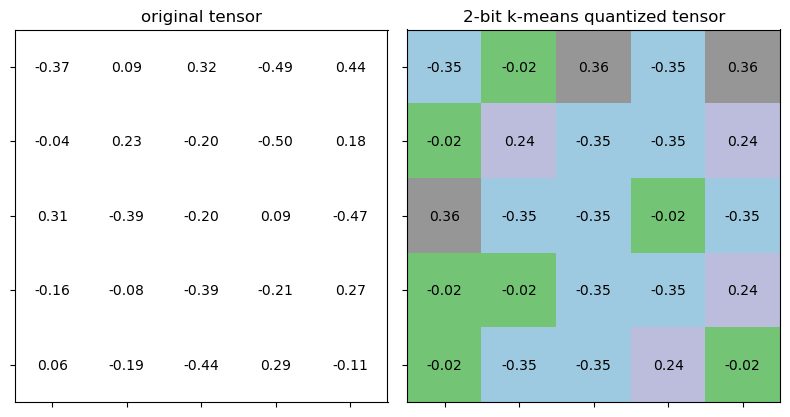

In [17]:
test_k_means_quantize()

In [18]:
quantizers = dict()
for bitwidth in [8, 4, 2]:
    recover_model()
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(model, bitwidth)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


    8-bit k-means quantized model has accuracy=92.75%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


    4-bit k-means quantized model has accuracy=83.99%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


    2-bit k-means quantized model has accuracy=12.28%


In [19]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor], the updated weight tensor
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
        codebook.centroids[k] = fp32_tensor[codebook.labels == k].mean()

In [20]:
accuracy_drop_threshold = 0.5
quantizers_before_finetune = copy.deepcopy(quantizers)
quantizers_after_finetune = quantizers

for bitwidth in [8, 4, 2]:
    recover_model()
    quantizer = quantizers[bitwidth]
    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer.apply(model, update_centroids=False)
    quantized_model_size = get_model_size(model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    quantized_model_accuracy = evaluate(model, dataloader['test'])
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}% before quantization-aware training ")
    accuracy_drop = fp32_model_accuracy - quantized_model_accuracy
    if accuracy_drop > accuracy_drop_threshold:
        print(f"        Quantization-aware training due to accuracy drop={accuracy_drop:.2f}% is larger than threshold={accuracy_drop_threshold:.2f}%")
        num_finetune_epochs = 5
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
        criterion = nn.CrossEntropyLoss()
        best_accuracy = 0
        epoch = num_finetune_epochs
        while accuracy_drop > accuracy_drop_threshold and epoch > 0:
            train(model, dataloader['train'], criterion, optimizer, scheduler,
                  callbacks=[lambda: quantizer.apply(model, update_centroids=True)])
            model_accuracy = evaluate(model, dataloader['test'])
            is_best = model_accuracy > best_accuracy
            best_accuracy = max(model_accuracy, best_accuracy)
            print(f'        Epoch {num_finetune_epochs-epoch} Accuracy {model_accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')
            accuracy_drop = fp32_model_accuracy - best_accuracy
            epoch -= 1
            
    else:
        print(f"        No need for quantization-aware training since accuracy drop={accuracy_drop:.2f}% is smaller than threshold={accuracy_drop_threshold:.2f}%")
    torch.save(model, f'./model/{bitwidth}bit_kmeans_quantized.pth')

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=8.80 MiB


    8-bit k-means quantized model has accuracy=92.75% before quantization-aware training 
        No need for quantization-aware training since accuracy drop=0.20% is smaller than threshold=0.50%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=4.40 MiB


    4-bit k-means quantized model has accuracy=83.99% before quantization-aware training 
        Quantization-aware training due to accuracy drop=8.96% is larger than threshold=0.50%


        Epoch 0 Accuracy 92.27% / Best Accuracy: 92.27%


        Epoch 1 Accuracy 92.48% / Best Accuracy: 92.48%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=2.20 MiB


    2-bit k-means quantized model has accuracy=12.28% before quantization-aware training 
        Quantization-aware training due to accuracy drop=80.67% is larger than threshold=0.50%


        Epoch 0 Accuracy 90.32% / Best Accuracy: 90.32%


        Epoch 1 Accuracy 91.07% / Best Accuracy: 91.07%


        Epoch 2 Accuracy 91.21% / Best Accuracy: 91.21%


        Epoch 3 Accuracy 91.41% / Best Accuracy: 91.41%


        Epoch 4 Accuracy 91.32% / Best Accuracy: 91.41%


# linear

In [21]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

In [22]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or 
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or 
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    scaled_tensor = fp_tensor / scale
    rounded_tensor = torch.round(scaled_tensor)

    rounded_tensor = rounded_tensor.to(dtype)

    shifted_tensor = rounded_tensor + zero_point

    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor

In [23]:
def test_linear_quantize(
    test_tensor=torch.tensor([
        [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
        [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
        [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
        [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
        [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]]),
    quantized_test_tensor=torch.tensor([
        [-1,  1, -1, -1,  0],
        [ 1,  1,  1, -2,  0],
        [-1,  0,  0,  1, -1],
        [-1, -1,  1,  1, -1],
        [ 1, -2,  1, -2,  0]], dtype=torch.int8),
    real_min=-0.25, real_max=0.75, bitwidth=2, scale=1/3, zero_point=-1):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    _quantized_test_tensor = linear_quantize(
        test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    assert _quantized_test_tensor.equal(quantized_test_tensor)
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()


* Test linear_quantize()
    target bitwidth: 2 bits
        scale: 0.3333333333333333
        zero point: -1
* Test passed.


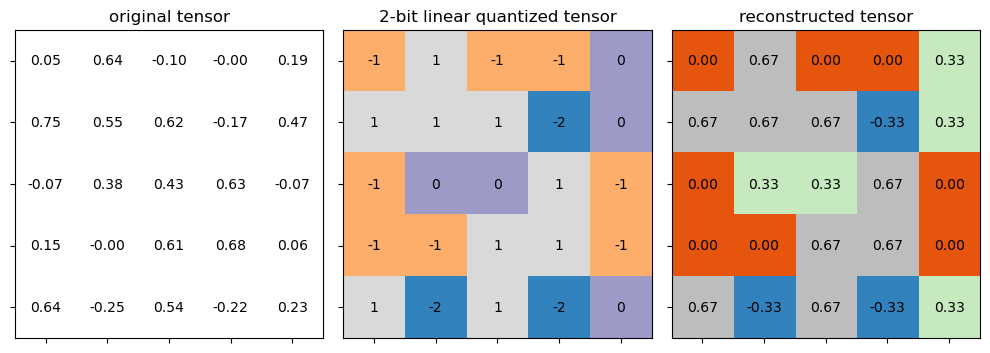

In [24]:
test_linear_quantize()

In [25]:
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()

    scale = (fp_max - fp_min) / (quantized_max - quantized_min)
    zero_point = int(round(quantized_min - fp_min / scale))

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

In [26]:
def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point

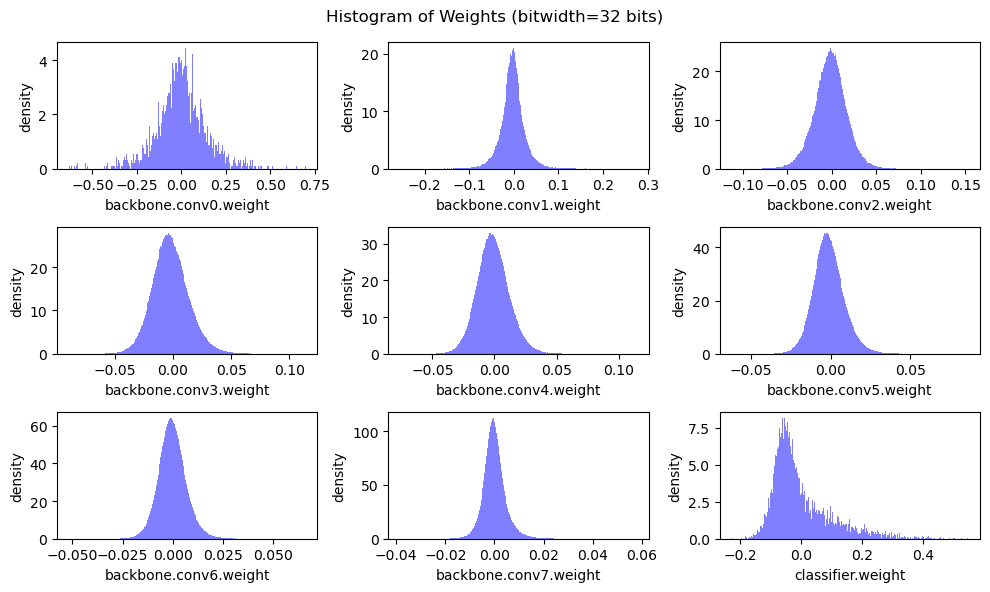

In [27]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True, 
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

recover_model()
plot_weight_distribution(model)

In [28]:
def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max

In [29]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

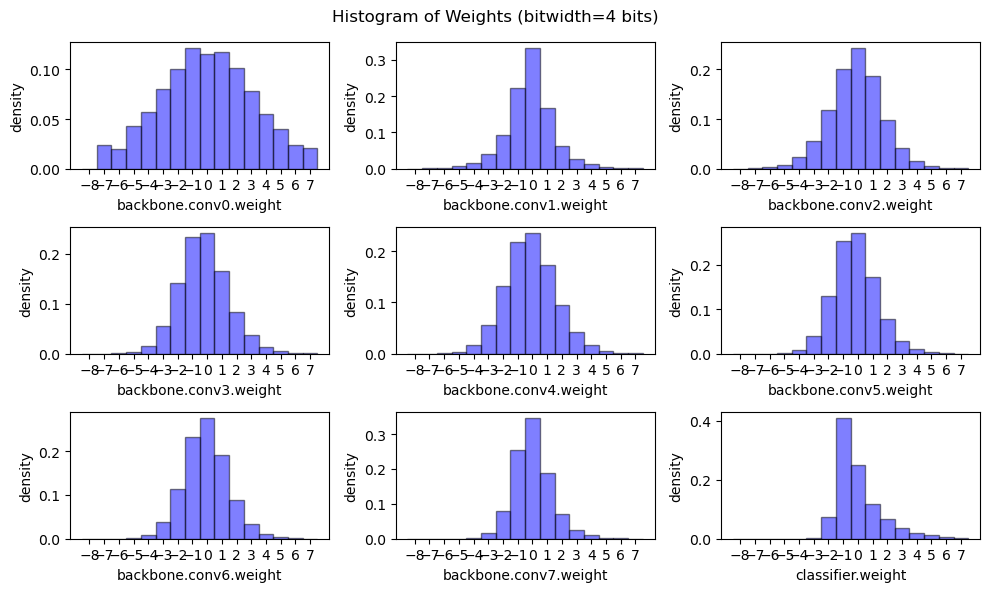

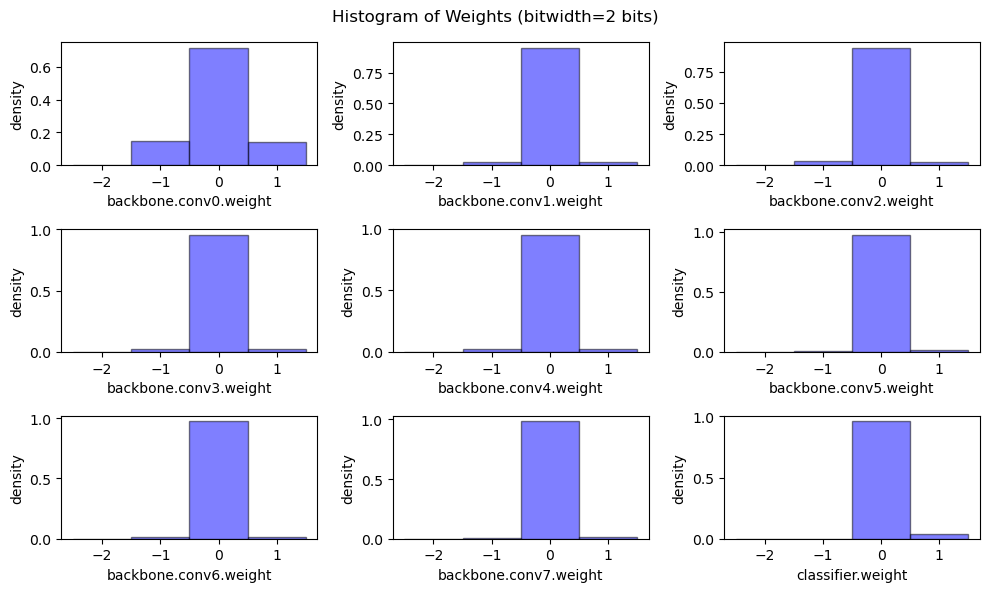

In [30]:
@torch.no_grad()
def peek_linear_quantization():
    for bitwidth in [4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)
        recover_model()

peek_linear_quantization()

In [31]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    bias_scale = weight_scale * input_scale

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

In [32]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

In [33]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # current version pytorch does not yet support integer-based linear() on GPUs
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())


    output = (input_scale * weight_scale / output_scale) * output.float().transpose(0, 1)

    output = output.transpose(0, 1) + output_zero_point


    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

In [34]:
def test_quantized_fc(
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]]),
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]]),
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502]),
    quantized_bias=torch.tensor([ 3, -2,  3,  1,  3,  2, -2, -2], dtype=torch.int32),
    shifted_quantized_bias=torch.tensor([-1,  0, -3, -1, -3,  0,  2, -4], dtype=torch.int32),
    calc_quantized_output=torch.tensor([
        [ 0, -1,  0, -1, -1,  0,  1, -2],
        [ 0,  0, -1,  0,  0,  0,  0, -1],
        [ 0,  0,  0, -1,  0,  0,  0, -1],
        [ 0,  0,  0,  0,  0,  1, -1, -2]], dtype=torch.int8),
    bitwidth=2, batch_size=4, in_channels=8, out_channels=8):
    def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")

    output = torch.nn.functional.linear(input, weight, bias)

    quantized_weight, weight_scale, weight_zero_point = \
        linear_quantize_weight_per_channel(weight, bitwidth)
    quantized_input, input_scale, input_zero_point = \
        linear_quantize_feature(input, bitwidth)
    _quantized_bias, bias_scale, bias_zero_point = \
        linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)
    assert _quantized_bias.equal(_quantized_bias)
    _shifted_quantized_bias = \
        shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)
    assert _shifted_quantized_bias.equal(shifted_quantized_bias)
    quantized_output, output_scale, output_zero_point = \
        linear_quantize_feature(output, bitwidth)

    _calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale)
    assert _calc_quantized_output.equal(calc_quantized_output)

    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(3,3, figsize=(15, 12))
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()

* Test quantized_fc()
    target bitwidth: 2 bits
      batch size: 4
      input channels: 8
      output channels: 8
* Test passed.


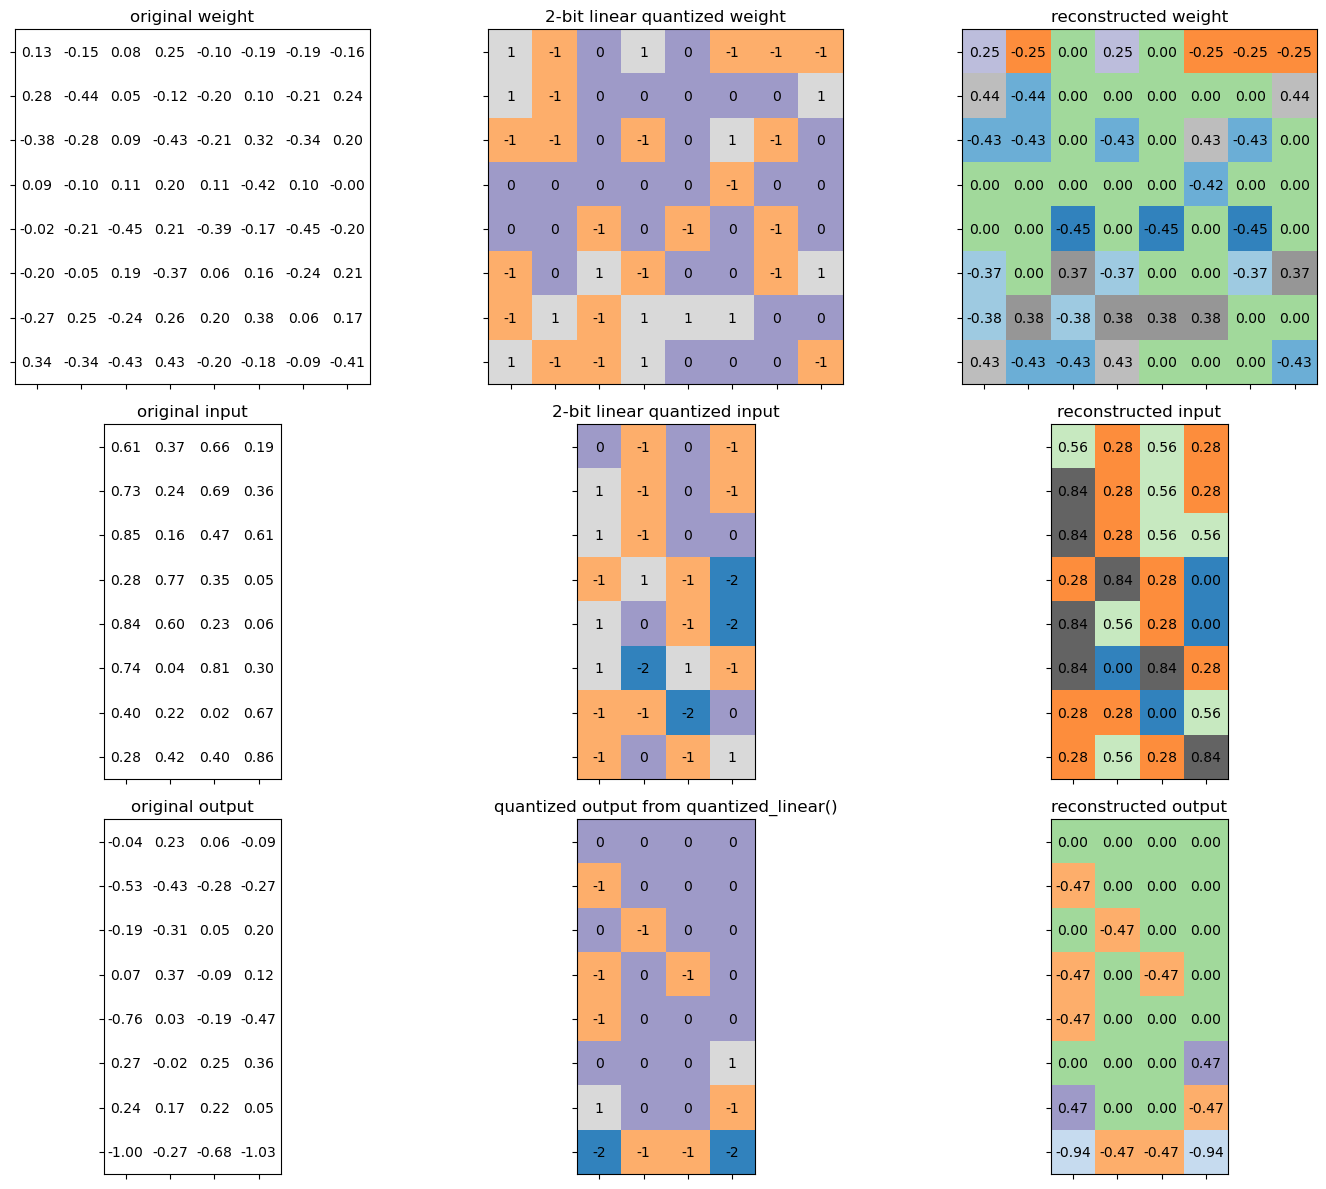

In [35]:
test_quantized_fc()

In [36]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

In [37]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    output = (input_scale * weight_scale / output_scale) * output.float().transpose(0, 1)

    output = output.transpose(0, 1) + output_zero_point

    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

In [38]:
def fuse_conv_bn(conv, bn):
    # modified from https://mmcv.readthedocs.io/en/latest/_modules/mmcv/cnn/utils/fuse_conv_bn.html
    assert conv.bias is None

    factor = bn.weight.data / torch.sqrt(bn.running_var.data + bn.eps)
    conv.weight.data = conv.weight.data * factor.reshape(-1, 1, 1, 1)
    conv.bias = nn.Parameter(- bn.running_mean.data * factor + bn.bias.data)

    return conv

print('Before conv-bn fusion: backbone length', len(model.backbone))
#  fuse the batchnorm into conv layers
recover_model()
model_fused = copy.deepcopy(model)
fused_backbone = []
ptr = 0
while ptr < len(model_fused.backbone):
    if isinstance(model_fused.backbone[ptr], nn.Conv2d) and \
        isinstance(model_fused.backbone[ptr + 1], nn.BatchNorm2d):
        fused_backbone.append(fuse_conv_bn(
            model_fused.backbone[ptr], model_fused.backbone[ptr+ 1]))
        ptr += 2
    else:
        fused_backbone.append(model_fused.backbone[ptr])
        ptr += 1
model_fused.backbone = nn.Sequential(*fused_backbone)

print('After conv-bn fusion: backbone length', len(model_fused.backbone))
# sanity check, no BN anymore
for m in model_fused.modules():
    assert not isinstance(m, nn.BatchNorm2d)

#  the accuracy will remain the same after fusion
fused_acc = evaluate(model_fused, dataloader['test'])
print(f'Accuracy of the fused model={fused_acc:.2f}%')

Before conv-bn fusion: backbone length 29
After conv-bn fusion: backbone length 21


Accuracy of the fused model=92.95%


In [39]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks

hooks = add_range_recoder_hook(model_fused)
sample_data = iter(dataloader['train']).__next__()[0]
model_fused(sample_data.cuda())

# remove hooks
for h in hooks:
    h.remove()


In [40]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias, 
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        return quantized_conv2d(
            x, self.weight, self.bias, 
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )
        
class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias, 
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        return quantized_linear(
            x, self.weight, self.bias, 
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return super().forward(x.float()).to(torch.int8)

class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based AvgPool
        return super().forward(x.float()).to(torch.int8)



In [ ]:
# we use int8 quantization, which is quite popular
feature_bitwidth = weight_bitwidth = 8 
quantized_model = copy.deepcopy(model_fused)
quantized_backbone = []
ptr = 0
while ptr < len(quantized_model.backbone):
    if isinstance(quantized_model.backbone[ptr], nn.Conv2d) and \
        isinstance(quantized_model.backbone[ptr + 1], nn.ReLU):
        conv = quantized_model.backbone[ptr]
        conv_name = f'backbone.{ptr}'
        relu = quantized_model.backbone[ptr + 1]
        relu_name = f'backbone.{ptr + 1}'

        input_scale, input_zero_point = \
            get_quantization_scale_and_zero_point(
                input_activation[conv_name], feature_bitwidth)
        
        output_scale, output_zero_point = \
            get_quantization_scale_and_zero_point(
                output_activation[relu_name], feature_bitwidth)

        quantized_weight, weight_scale, weight_zero_point = \
            linear_quantize_weight_per_channel(conv.weight.data, weight_bitwidth)
        quantized_bias, bias_scale, bias_zero_point = \
            linear_quantize_bias_per_output_channel(
                conv.bias.data, weight_scale, input_scale)
        shifted_quantized_bias = \
            shift_quantized_conv2d_bias(quantized_bias, quantized_weight, 
                                        input_zero_point)
            
        quantized_conv = QuantizedConv2d(
            quantized_weight, shifted_quantized_bias,
            input_zero_point, output_zero_point,
            input_scale, weight_scale, output_scale,
            conv.stride, conv.padding, conv.dilation, conv.groups,
            feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
        )

        quantized_backbone.append(quantized_conv)
        ptr += 2
    elif isinstance(quantized_model.backbone[ptr], nn.MaxPool2d):
        quantized_backbone.append(QuantizedMaxPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    elif isinstance(quantized_model.backbone[ptr], nn.AvgPool2d):
        quantized_backbone.append(QuantizedAvgPool2d(
            kernel_size=quantized_model.backbone[ptr].kernel_size,
            stride=quantized_model.backbone[ptr].stride
            ))
        ptr += 1
    else:
        raise NotImplementedError(type(quantized_model.backbone[ptr]))  # should not happen
quantized_model.backbone = nn.Sequential(*quantized_backbone)

# finally, quantized the classifier
fc_name = 'classifier'
fc = model.classifier
input_scale, input_zero_point = \
    get_quantization_scale_and_zero_point(
        input_activation[fc_name], feature_bitwidth)

output_scale, output_zero_point = \
    get_quantization_scale_and_zero_point(
        output_activation[fc_name], feature_bitwidth)

quantized_weight, weight_scale, weight_zero_point = \
    linear_quantize_weight_per_channel(fc.weight.data, weight_bitwidth)
quantized_bias, bias_scale, bias_zero_point = \
    linear_quantize_bias_per_output_channel(
        fc.bias.data, weight_scale, input_scale)
shifted_quantized_bias = \
    shift_quantized_linear_bias(quantized_bias, quantized_weight, 
                                input_zero_point)
            
quantized_model.classifier = QuantizedLinear(
    quantized_weight, shifted_quantized_bias,
    input_zero_point, output_zero_point,
    input_scale, weight_scale, output_scale,
    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
)

In [43]:
print(quantized_model)

def extra_preprocess(x):
    return (x*255 - 128).clamp(-128, 127).to(torch.int8)

int8_model_accuracy = evaluate(quantized_model, dataloader['test'],
                               extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")
torch.save(quantized_model, './model/8bit_linear_quantized.pth')

VGG(
  (backbone): Sequential(
    (0): QuantizedConv2d()
    (1): QuantizedConv2d()
    (2): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): QuantizedConv2d()
    (4): QuantizedConv2d()
    (5): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): QuantizedConv2d()
    (7): QuantizedConv2d()
    (8): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): QuantizedConv2d()
    (10): QuantizedConv2d()
    (11): QuantizedMaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): QuantizedAvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): QuantizedLinear()
)


int8 model has accuracy=92.88%
